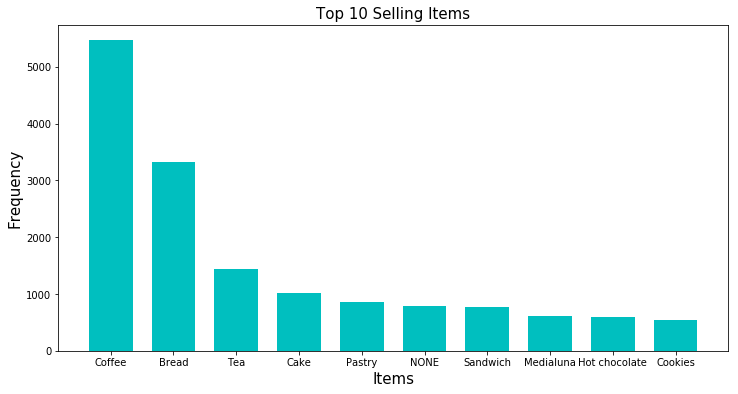

,Item
Transaction,
1,Bread
2,Scandinavian
2,Scandinavian
3,Hot chocolate
3,Jam
3,Cookies
4,Muffin
5,Coffee
5,Pastry


Starting order_item:                  21293
Items with support >= 0.01:              31
Remaining order_item:                 20286
Remaining orders with 2+ items:        5828
Remaining order_item:                 16748
Item pairs:                             841
Item pairs with support >= 0.01:         67



,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Hot chocolate,Cookies,59,0.010124,533,0.091455,497,0.085278,0.110694,0.118712,1.298040
50,Sandwich,Sandwich,96,0.016472,710,0.121826,710,0.121826,0.135211,0.135211,1.109875
46,Hot chocolate,Cake,91,0.015614,533,0.091455,921,0.158030,0.170732,0.098806,1.080374
64,Coffee,Toast,238,0.040837,4471,0.767159,304,0.052162,0.053232,0.782895,1.020512
33,Tea,Cake,193,0.033116,1273,0.218428,921,0.158030,0.151610,0.209555,0.959376


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn import preprocessing 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display
df=pd.read_csv('apriori.csv')
items = df['Item'].value_counts().index
item_frequency = df['Item'].value_counts().values
plt.figure(figsize=(12,6))
plt.xlabel('Items', fontsize='15')
plt.ylabel('Frequency', fontsize='15')
plt.title('Top 10 Selling Items', fontsize='15')
plt.bar(items[:10],item_frequency[:10], width = 0.7, color='c',linewidth=0.4)
plt.show()
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")
    
def order_count(order_item):
    return len(set(order_item.index))

def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]
def association_rules(order_item, min_support):
    print("Starting order_item: {:22d}".format(len(order_item)))
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item)
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]
    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]
    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item)
    item_pair_gen          = get_item_pairs(order_item)
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders)
    print("Item pairs: {:31d}".format(len(item_pairs)))
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]
    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    return item_pairs.sort_values('lift', ascending=False)
orders_series = df.set_index('Transaction')['Item']
display(pd.DataFrame(orders_series.head(10)))
rules = association_rules(orders_series, 0.01)
display(rules.head(5))